# sales Forecasting for Toys  

**Objective**: Predict daily product sales across stores data to optimize stock levels and reduce costs.  

**Approach**:  
1. **Clean and merge** transactional data.  
2. **Explore patterns** (seasonality, top-selling categories).  
3. **Engineer features** (lags, inventory flags) for machine learning.  
4. **Train Random Forest & XGBoost** and explain predictions.  

In [7]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

### Load Data   

In [9]:
sales = pd.read_csv("data/sales.csv")
products = pd.read_csv("data/products.csv")
stores = pd.read_csv("data/stores.csv")
inventory = pd.read_csv("data/inventory.csv")

### Clean Data  
Handle missing values, duplicates, and formatting:  
- **Sales**: Drop rows with missing `Product_ID` or negative `Units`.  
- **Products**: Convert prices from `$X.XX` to numeric.  
- **Inventory**: Flag stockouts (`Stock_On_Hand = 0`).  

In [10]:
def clean_data(sales, products, stores, inventory):
    # Drop rows with critical missing values
    sales.dropna(subset=['Product_ID', 'Store_ID', 'Units', 'Date'], inplace=True)
    products.dropna(subset=['Product_ID', 'Product_Price', 'Product_Cost'], inplace=True)
    stores.dropna(subset=['Store_ID'], inplace=True)

    # Add duplicate check
    sales.drop_duplicates(subset=['Sale_ID'], inplace=True)

    # Clean and convert price columns early
    products['Product_Cost'] = products['Product_Cost'].astype(str).str.replace('$', '').str.replace(' ', '')
    products['Product_Price'] = products['Product_Price'].astype(str).str.replace('$', '').str.replace(' ', '')
    products['Product_Cost'] = pd.to_numeric(products['Product_Cost'], errors='coerce')
    products['Product_Price'] = pd.to_numeric(products['Product_Price'], errors='coerce')

    # Convert date columns
    sales['Date'] = pd.to_datetime(sales['Date'], errors='coerce')
    sales.dropna(subset=['Date'], inplace=True)

    # Remove invalid values
    sales = sales[sales['Units'] >= 0]
    products = products[products['Product_Price'] > 0]
    products = products[products['Product_Cost'] >= 0]

    # Clean inventory 
    inventory.dropna(subset=['Store_ID', 'Product_ID'], inplace=True)
    inventory['Stock_On_Hand'] = pd.to_numeric(inventory['Stock_On_Hand'], errors='coerce')
    inventory = inventory[inventory['Stock_On_Hand'] >= 0]

    return sales, products, stores, inventory

In [11]:
sales, products, stores, inventory = clean_data(sales, products, stores, inventory)

### Merge Data  

In [12]:
def merge_and_prepare(sales, products, stores):
    merged = sales.merge(products, on="Product_ID").merge(stores, on="Store_ID")

    # Create new columns for total sales and total cost
    merged['sales'] = merged['Units'] * merged['Product_Price']
    merged['cost'] = merged['Units'] * merged['Product_Cost']
    merged['Date'] = pd.to_datetime(merged['Date'])

    return merged

In [13]:
merged_data = merge_and_prepare(sales, products, stores)

### Feature Engineering  
Create time-based and aggregate features:  
- **Time Features**: `Day_of_Week`, `Month`, `Is_Weekend`.  
- **Lag Features**: `Lag_1_Day`, `Lag_7_Day` (previous sales).  
- **Inventory Signals**: `Stockout_Flag`, `Inventory_Turnover`.  

In [14]:
def engineer_features(merged):
    # Time features
    merged['Day_of_Week'] = merged['Date'].dt.dayofweek
    merged['Month'] = merged['Date'].dt.month
    merged['Is_Weekend'] = (merged['Day_of_Week'] >= 5).astype(int)
    
    # Lag features (sort first!)
    merged = merged.sort_values(['Store_ID', 'Product_ID', 'Date'])
    merged['Lag_1_Day'] = merged.groupby(['Store_ID', 'Product_ID'])['Units'].shift(1)
    merged['Lag_7_Day'] = merged.groupby(['Store_ID', 'Product_ID'])['Units'].shift(7)
    
    #Handle NaNs
    merged['Lag_1_Day'] = merged['Lag_1_Day'].fillna(0)  # No prior data = assume 0
    merged['Lag_7_Day'] = merged['Lag_7_Day'].fillna(0)

    # Rolling stats
    merged['Rolling_Avg_7'] = merged.groupby(['Store_ID', 'Product_ID'])['Units'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    merged['Rolling_Std_7'] = (
    merged.groupby(['Store_ID', 'Product_ID'])['Units']
    .transform(lambda x: x.rolling(7, min_periods=1).std())
    )
    
    # Product/store aggregates
    # Avg sales per product category
    merged['Category_Avg_Sales'] = merged.groupby('Product_Category')['Units'].transform('mean')

    # Store performance (percentile rank)
    merged['Store_Percentile'] = merged.groupby('Store_ID')['sales'].rank(pct=True)

    # Sales-Based Stockout Proxies
    # Flag sudden sales drops to zero
    prev_day_sales = merged.groupby(['Store_ID', 'Product_ID'])['Units'].shift(1)
    merged['Sales_Drop_Flag'] = ((merged['Units'] == 0) & (prev_day_sales > 0)).astype(int)

    # Track consecutive days with zero sales
    merged['Consecutive_Zero_Sales'] = (
        merged.groupby(['Store_ID', 'Product_ID'])['Units']
        .transform(lambda x: x.groupby((x != 0).cumsum()).cumcount())
    )

    # Price Elasticity Features
    merged['Price_Change'] = merged.groupby('Product_ID')['Product_Price'].diff()
    merged['Price_Increase_Flag'] = (merged['Price_Change'] > 0).astype(int)

    return merged

In [15]:
merged_data = engineer_features(merged_data)

In [16]:
merged_data.head(20)

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,...,Lag_1_Day,Lag_7_Day,Rolling_Avg_7,Rolling_Std_7,Category_Avg_Sales,Store_Percentile,Sales_Drop_Flag,Consecutive_Zero_Sales,Price_Change,Price_Increase_Flag
1209,1210,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,0.0,0.0,1.0,NaN,1.207809,0.626962,0,0,NaN,0
1248,1249,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
1271,1272,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
1274,1275,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
1590,1591,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
1630,1631,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
1720,1721,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,0.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
2006,2007,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,1.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
2086,2087,2017-01-02,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,1.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0
2809,2810,2017-01-04,1,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,...,1.0,1.0,1.0,0.0,1.207809,0.626962,0,0,0.0,0


### Exploratory Data Analysis (EDA)

In [17]:
def run_eda(merged):
    print("\n--- Descriptive Statistics ---")
    print(merged.describe())
    print("\n--- Missing Values ---")
    print(merged.isnull().sum())
    #Top 3 cities by sales
    top_cities = merged.groupby('Store_City')['sales'].sum().sort_values(ascending=False).nlargest(3)
    print("\n---Top 3 Cities by Sales ---")
    print(top_cities)

    #Seasonality Check
    plt.figure(figsize=(12, 6))
    plot_acf(merged.groupby('Date')['Units'].sum(), lags=30)
    plt.title("Autocorrelation (Lags 1-30)")
    plt.show()
    
    #Store-Category Heatmap
    sales_pivot = merged.pivot_table(index='Store_City', columns='Product_Category', values='Units', aggfunc='sum')
    plt.figure(figsize=(12, 8))
    sns.heatmap(sales_pivot.fillna(0), cmap='viridis', annot=True, fmt='.0f')
    plt.title("Units Sold by Store City & Product Category")
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(merged['Units'], bins=30, kde=True)
    plt.title("Distribution of Units Sold")
    plt.xlabel("Units")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Product_Category", y="Units", data=merged)
    plt.title("Units Sold by Product Category")
    plt.show()

    # --- Profit Trend Visualization ---
    merged['profit'] = merged['sales'] - merged['cost']
    profit_trend = merged.groupby('Date')['profit'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=profit_trend, x='Date', y='profit')
    plt.title("Daily Profit Trend")
    plt.xlabel("Date")
    plt.ylabel("Profit ($)")
    plt.show()

    # --- Daily vs Weekly vs Monthly Mean Sales ---
    sales_daily = merged.groupby('Date')['sales'].sum()
    sales_daily_df = pd.DataFrame(sales_daily)
    sales_weekly_mean = sales_daily_df['sales'].resample('W').mean()
    sales_monthly_mean = sales_daily_df['sales'].resample('M').mean()

    plt.figure(figsize=(16, 6))
    plt.plot(sales_daily_df['sales'], label='Daily')
    plt.plot(sales_weekly_mean, label='Weekly Mean')
    plt.plot(sales_monthly_mean, label='Monthly Mean')
    plt.title("Sales Resampling: Daily vs Weekly vs Monthly Mean")
    plt.xlabel("Date")
    plt.ylabel("Sales ($)")
    plt.legend()
    plt.show()


--- Descriptive Statistics ---
             Sale_ID                           Date       Store_ID  \
count  829262.000000                         829262  829262.000000   
mean   414631.500000  2017-12-10 22:14:40.102066176      25.277034   
min         1.000000            2017-01-01 00:00:00       1.000000   
25%    207316.250000            2017-07-09 00:00:00      13.000000   
50%    414631.500000            2017-12-28 00:00:00      26.000000   
75%    621946.750000            2018-05-13 00:00:00      38.000000   
max    829262.000000            2018-09-30 00:00:00      50.000000   
std    239387.463802                            NaN      14.352573   

          Product_ID          Units   Product_Cost  Product_Price  \
count  829262.000000  829262.000000  829262.000000  829262.000000   
mean       15.014149       1.315103       9.976460      13.772327   
min         1.000000       1.000000       1.990000       2.990000   
25%         6.000000       1.000000       3.990000       6.99

<Figure size 1200x600 with 0 Axes>

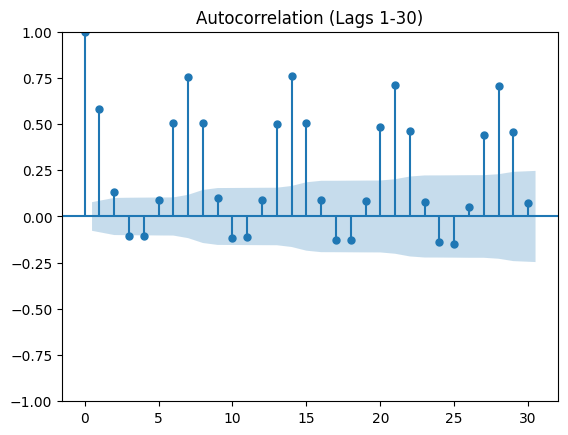

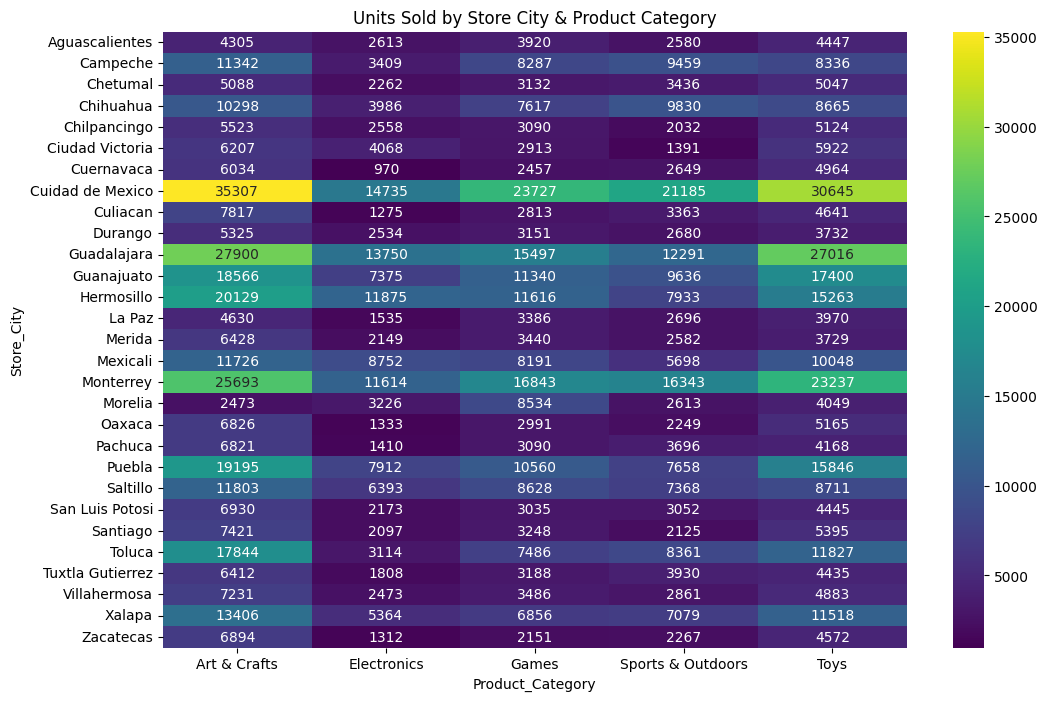

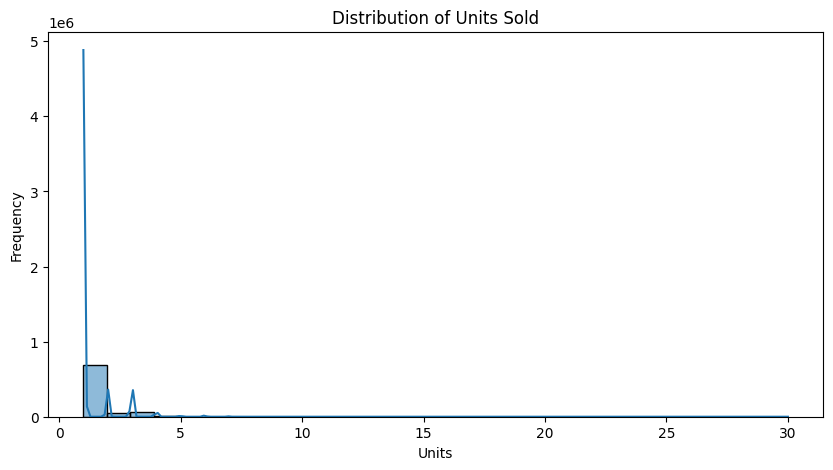

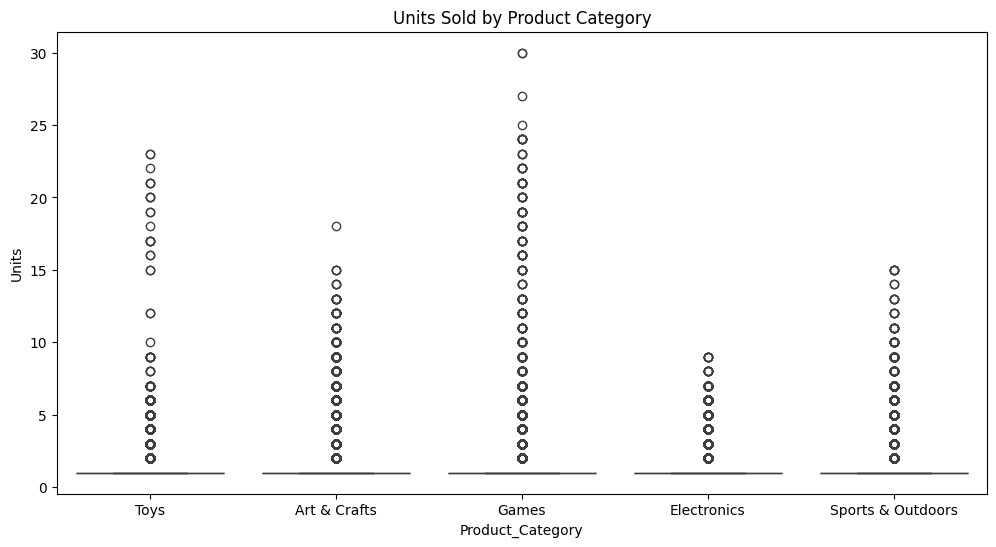

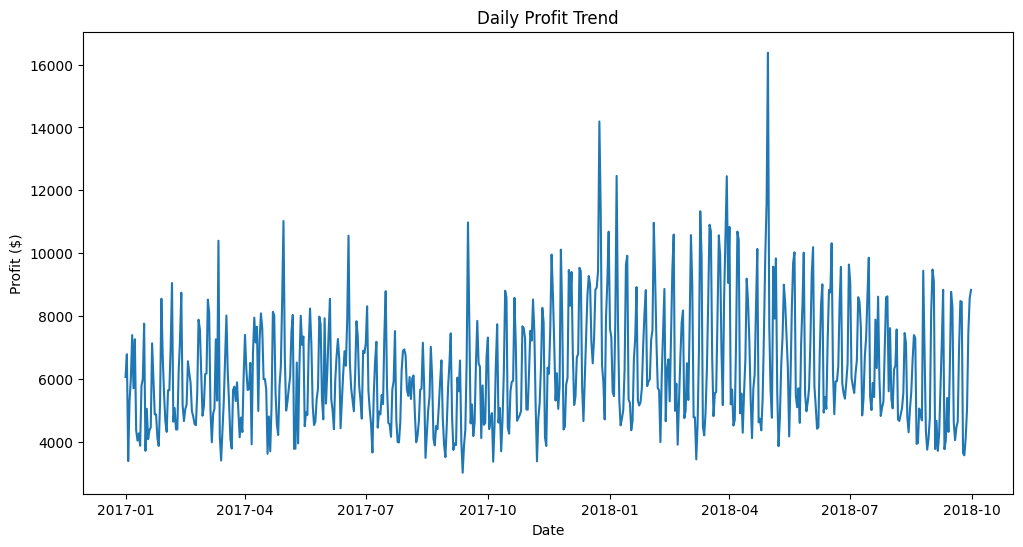

C:\Users\knedi\AppData\Local\Temp\ipykernel_14992\4214712658.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_monthly_mean = sales_daily_df['sales'].resample('M').mean()


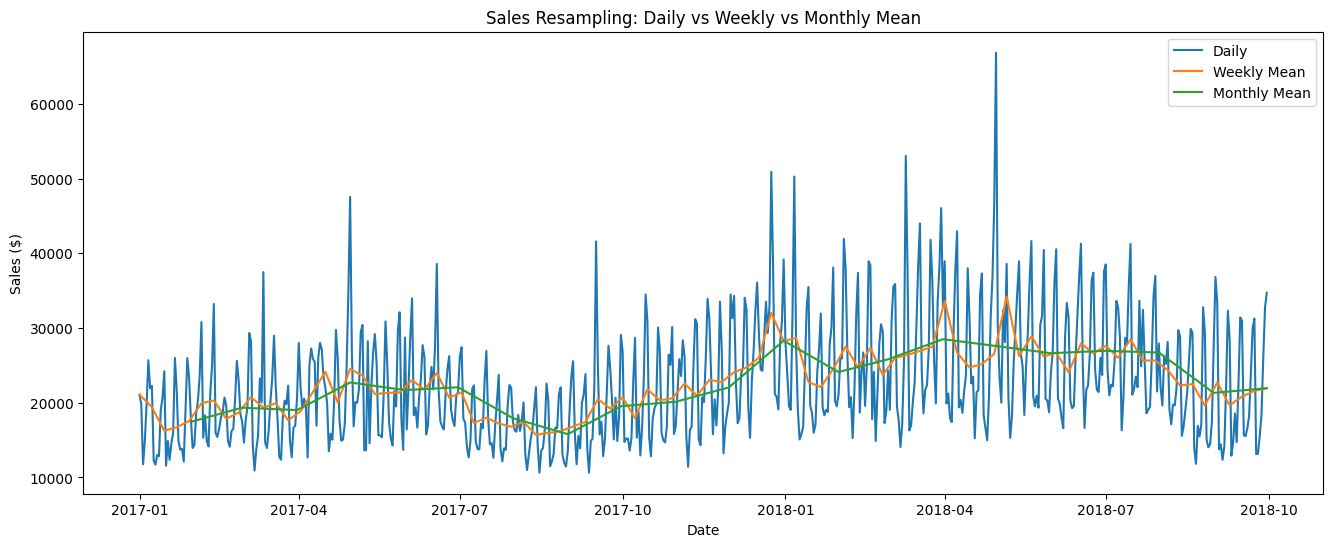

In [18]:
run_eda(merged_data)

## Train Model
To forecast daily sales at the product-store level, we implemented **Random Forest Regressor** & **XGBoost**— powerful ensemble learning method known for its robustness and ability to handle complex patterns.


#### Feature Engineering

We selected key features that capture temporal trends, store dynamics, and product behavior:

- **Temporal features**: `Day_of_Week`, `Month`, `Is_Weekend`
- **Lag features**: `Lag_1_Day`, `Lag_7_Day`
- **Rolling statistics**: `Rolling_Avg_7`
- **Sales behavior flags**: `Sales_Drop_Flag`, `Consecutive_Zero_Sales`
- **Category & store dynamics**: `Category_Avg_Sales`, `Store_Percentile`

#### Chronological Train-Test Split

To preserve the time series nature of the data:

- The dataset was sorted by `Date`.
- The last 20% of the timeline was held out as a **test set** to evaluate the model’s ability to predict unseen future sales.


In [19]:

# Define features and target
features = [
    'Day_of_Week', 'Month', 'Is_Weekend',
    'Lag_1_Day', 'Lag_7_Day', 'Rolling_Avg_7',
    'Sales_Drop_Flag', 'Consecutive_Zero_Sales', 
    'Category_Avg_Sales', 'Store_Percentile'
]
target = 'Units'

# Sort by date first to ensure chronological order
merged_data = merged_data.sort_values('Date')

# Define split point (e.g., last 20% of dates for test)
split_date = merged_data['Date'].quantile(0.8, interpolation='nearest')
print(f"Splitting at: {split_date}")  

train = merged_data[merged_data['Date'] < split_date]
test = merged_data[merged_data['Date'] >= split_date]


Splitting at: 2018-06-09 00:00:00


In [20]:
# Verify split sizes
print(f"Train dates: {train['Date'].min()} to {train['Date'].max()}")
print(f"Test dates: {test['Date'].min()} to {test['Date'].max()}")
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train dates: 2017-01-01 00:00:00 to 2018-06-08 00:00:00
Test dates: 2018-06-09 00:00:00 to 2018-09-30 00:00:00
Train size: 662414, Test size: 166848


#### Random Forest

A **Random Forest Regressor** was trained using the training set:

- `n_estimators=200`: Number of decision trees
- `max_depth=10`: Limits the depth of each tree to reduce overfitting
- `random_state=42`: Ensures reproducibility

In [21]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42  # For reproducibility
)
model.fit(train[features], train[target])

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

### XGBoost
We've added XGBoost (Extreme Gradient Boosting) as a second predictive model because:
- It often provides superior performance for structured/tabular data
- Handles non-linear relationships well
- Automatically learns feature interactions
- Provides built-in regularization to prevent overfitting

Key parameters configured:
- `n_estimators=200`: Number of boosting rounds
- `max_depth=6`: Maximum tree depth
- `learning_rate=0.1`: Step size shrinkage
- `subsample=0.8`: Fraction of samples used per tree
- `colsample_bytree=0.8`: Fraction of features used per tree

In [22]:
# XGBoost Model Training
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#### Performance Evaluation

The model’s predictions were evaluated using the following metrics:

- **MAE (Mean Absolute Error)**: Measures the average size of the errors in units, treating all errors equally regardless of their direction.
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors, penalizing larger errors more heavily. Lower RMSE indicates better model performance.
- **R² Score (Coefficient of Determination)**: Indicates how well your model explains the variability in the target variable—in this case, sales in units. A higher R² means the model captures more of the variation in the data.
- **Naive Baseline**: Uses `Lag_1_Day` (sales from the previous day) as a simple benchmark to compare model performance.


In [23]:

predictions = model.predict(test[features])

# Calculate metrics
mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))
r2 = r2_score(test[target], predictions)

print(f"\nRandom Forest Performance:")
print(f"MAE: {mae:.2f} units")
print(f"RMSE: {rmse:.2f} units")
print(f"R² Score: {r2:.4f}")

# Naive baseline (Lag-1)
naive_mae = mean_absolute_error(test[target], test['Lag_1_Day'])
print(f"Naive MAE (Lag-1 baseline): {naive_mae:.2f} units")

# Check if model beats baseline
improvement = (naive_mae - mae) / naive_mae * 100
print(f"Model improvement over naive: {improvement:.1f}%")


Random Forest Performance:
MAE: 0.06 units
RMSE: 0.24 units
R² Score: 0.8948
Naive MAE (Lag-1 baseline): 0.13 units
Model improvement over naive: 54.0%


In [24]:
# Train XGBoost on the same training data
xgb_model.fit(train[features], train[target])

# Make predictions
xgb_predictions = xgb_model.predict(test[features])

# Calculate metrics
xgb_mae = mean_absolute_error(test[target], xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(test[target], xgb_predictions))
xgb_r2 = r2_score(test[target], xgb_predictions)

# Compare with naive baseline
xgb_improvement = (naive_mae - xgb_mae) / naive_mae * 100

# Compare with Random Forest
print("\nXGBoost Performance:")
print(f"MAE: {xgb_mae:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"R² Score: {xgb_r2:.4f}")
print(f"Improvement over naive baseline: {xgb_improvement:.1f}%")


XGBoost Performance:
MAE: 0.0757
RMSE: 0.2350
R² Score: 0.9007
Improvement over naive baseline: 43.2%


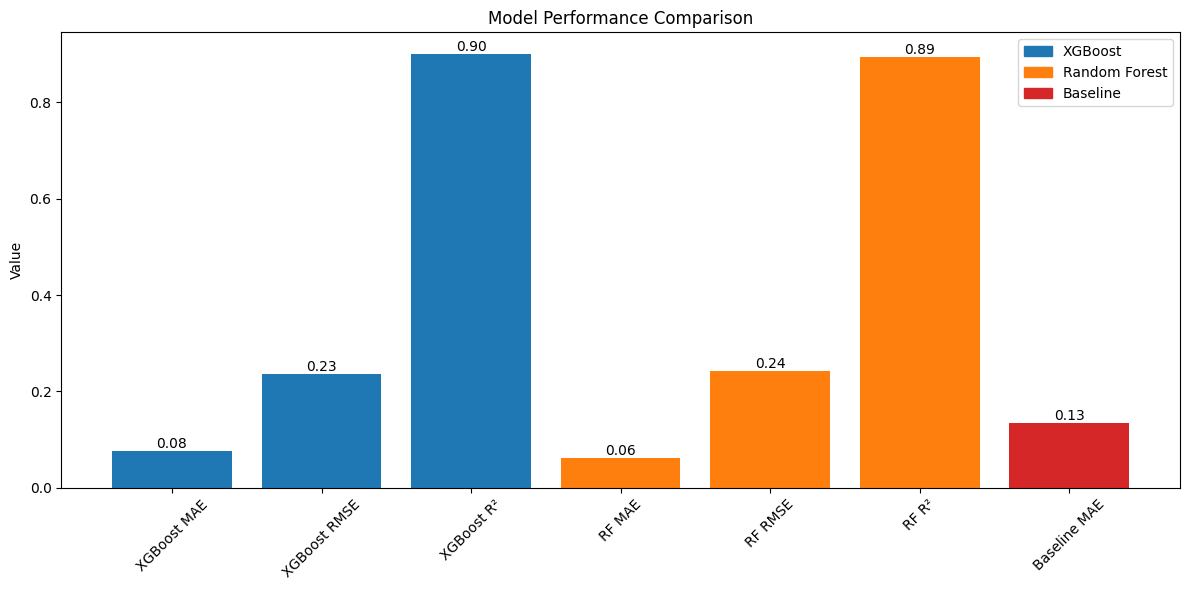

In [25]:
# --- Performance Metrics Plot ---
# Combined Performance Metrics Plot
metrics = {
    'XGBoost MAE': xgb_mae,
    'XGBoost RMSE': xgb_rmse,
    'XGBoost R²': xgb_r2,
    'RF MAE': mae,
    'RF RMSE': rmse,
    'RF R²': r2,
    'Baseline MAE': naive_mae
}

plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#1f77b4', '#1f77b4', 
          '#ff7f0e', '#ff7f0e', '#ff7f0e',
          '#d62728']
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.title('Model Performance Comparison')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Add legend
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='#1f77b4', label='XGBoost'),
    mpatches.Patch(color='#ff7f0e', label='Random Forest'),
    mpatches.Patch(color='#d62728', label='Baseline')
]
plt.legend(handles=legend_patches)

plt.tight_layout()
plt.show()

C:\Users\knedi\AppData\Local\Temp\ipykernel_14992\1358332601.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_feature_importance, x='Importance', y='Feature', palette='viridis')
C:\Users\knedi\AppData\Local\Temp\ipykernel_14992\1358332601.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feature_importance, x='Importance', y='Feature', palette='viridis')


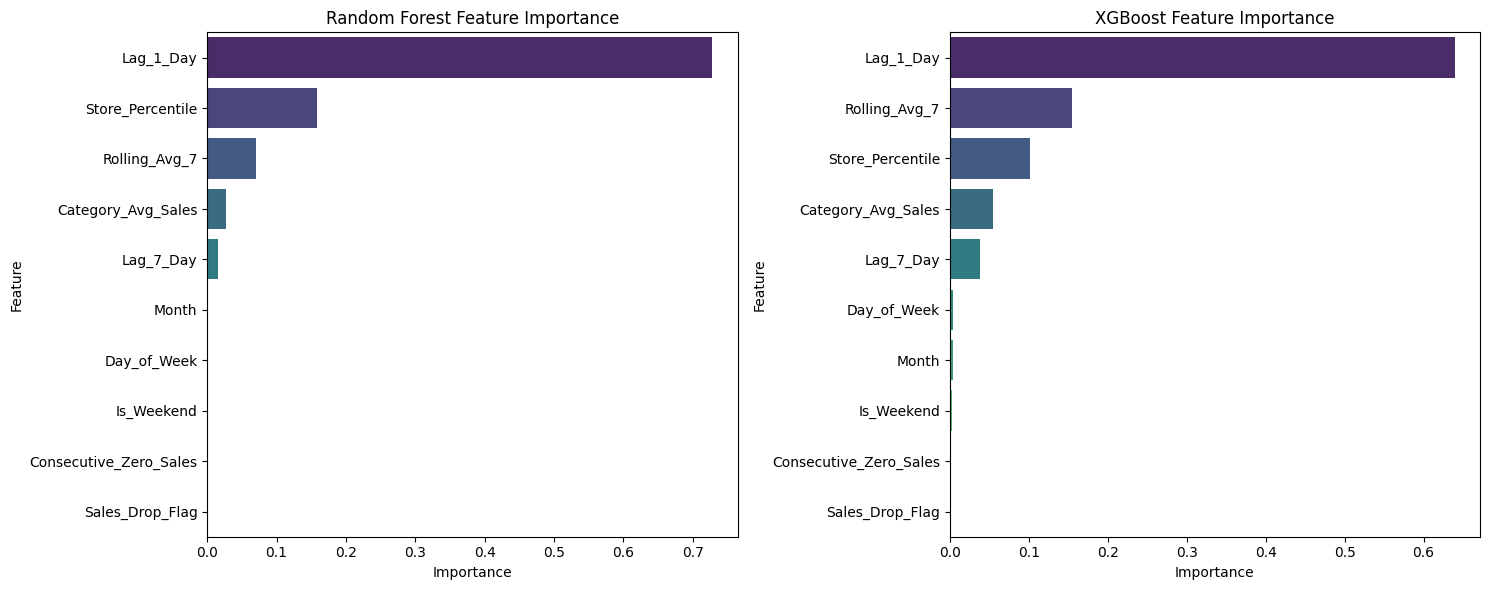

In [26]:
# --- Feature Importance Visualization ---
plt.figure(figsize=(15, 6))

# Random Forest Feature Importance
plt.subplot(1, 2, 1)
rf_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(data=rf_feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest Feature Importance')

# XGBoost Feature Importance
plt.subplot(1, 2, 2)
xgb_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(data=xgb_feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

#### Cross-Validation with TimeSeriesSplit

To ensure robust performance across different time periods, we applied **Time Series Cross-Validation** with 5 folds.

In [27]:
# TimeSeriesSplit cross-validation for Random Forest
# Define features and target
features = [
    'Day_of_Week', 'Month', 'Is_Weekend',
    'Lag_1_Day', 'Lag_7_Day', 'Rolling_Avg_7',
    'Sales_Drop_Flag', 'Consecutive_Zero_Sales', 
    'Category_Avg_Sales', 'Store_Percentile'
]
target = 'Units'

# Sort the dataset by date
merged_data = merged_data.sort_values('Date').reset_index(drop=True)

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # You can change to other metrics if needed
    n_jobs=-1,
    verbose=2
)

# Fit GridSearch to find best hyperparameters
grid_search.fit(merged_data[features], merged_data[target])

# Best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Evaluate performance of the best model on each fold
mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(merged_data)):
    train_fold = merged_data.iloc[train_idx]
    val_fold = merged_data.iloc[val_idx]
    
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(train_fold[features], train_fold[target])
    
    val_preds = model.predict(val_fold[features])
    
    fold_mae = mean_absolute_error(val_fold[target], val_preds)
    fold_rmse = np.sqrt(mean_squared_error(val_fold[target], val_preds))
    fold_r2 = r2_score(val_fold[target], val_preds)
    
    mae_scores.append(fold_mae)
    rmse_scores.append(fold_rmse)
    r2_scores.append(fold_r2)
    
    print(f"Fold {fold+1} - MAE: {fold_mae:.4f}, RMSE: {fold_rmse:.4f}, R²: {fold_r2:.4f}")

# Average metrics
print("\nCross-Validation Summary:")
print(f"Avg MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Avg R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# ---- Final model training ----
# Split the full dataset into train (80%) and test (20%) chronologically
split_date = merged_data['Date'].quantile(0.8, interpolation='nearest')
train_final = merged_data[merged_data['Date'] < split_date]
test_final = merged_data[merged_data['Date'] >= split_date]

# Retrain best model on full training set
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(train_final[features], train_final[target])
print("\n✅ Final model trained on full training set (80%)")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters Found: {'max_depth': 20, 'n_estimators': 200}
Fold 1 - MAE: 0.0387, RMSE: 0.1921, R²: 0.9431
Fold 2 - MAE: 0.0636, RMSE: 0.2817, R²: 0.8991
Fold 3 - MAE: 0.0651, RMSE: 0.2868, R²: 0.9013
Fold 4 - MAE: 0.0395, RMSE: 0.2049, R²: 0.9446
Fold 5 - MAE: 0.0402, RMSE: 0.2130, R²: 0.9144

Cross-Validation Summary:
Avg MAE: 0.0494 ± 0.0122
Avg RMSE: 0.2357 ± 0.0402
Avg R²: 0.9205 ± 0.0198

✅ Final model trained on full training set (80%)


In [28]:
# TimeSeriesSplit cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

xgb_mae_scores = []
xgb_rmse_scores = []
xgb_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(merged_data)):
    train_fold = merged_data.iloc[train_idx]
    val_fold = merged_data.iloc[val_idx]
    
    # Train XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(train_fold[features], train_fold[target])
    
    # Predict
    val_preds = xgb_model.predict(val_fold[features])
    
    # Evaluate
    fold_mae = mean_absolute_error(val_fold[target], val_preds)
    fold_rmse = np.sqrt(mean_squared_error(val_fold[target], val_preds))
    fold_r2 = r2_score(val_fold[target], val_preds)
    
    xgb_mae_scores.append(fold_mae)
    xgb_rmse_scores.append(fold_rmse)
    xgb_r2_scores.append(fold_r2)
    print(f"XGBoost Fold {fold+1} - MAE: {fold_mae:.4f}, RMSE: {fold_rmse:.4f}, R² Score: {fold_r2:.4f}")

# Overall XGBoost scores
print(f"\nXGBoost Cross-Validation Results:")
print(f"Avg MAE: {np.mean(xgb_mae_scores):.4f} ± {np.std(xgb_mae_scores):.4f}")
print(f"Avg RMSE: {np.mean(xgb_rmse_scores):.4f} ± {np.std(xgb_rmse_scores):.4f}")
print(f"Avg R² Score: {np.mean(xgb_r2_scores):.4f} ± {np.std(xgb_r2_scores):.4f}")


XGBoost Fold 1 - MAE: 0.0610, RMSE: 0.2107, R² Score: 0.9315
XGBoost Fold 2 - MAE: 0.0859, RMSE: 0.2966, R² Score: 0.8881
XGBoost Fold 3 - MAE: 0.0885, RMSE: 0.2932, R² Score: 0.8969
XGBoost Fold 4 - MAE: 0.0768, RMSE: 0.2460, R² Score: 0.9202
XGBoost Fold 5 - MAE: 0.0727, RMSE: 0.2300, R² Score: 0.9002

XGBoost Cross-Validation Results:
Avg MAE: 0.0770 ± 0.0099
Avg RMSE: 0.2553 ± 0.0342
Avg R² Score: 0.9074 ± 0.0160


In [29]:
print("\nRF worst predictions")  
test['Predicted'] = predictions
test['Error'] = abs(test['Units'] - test['Predicted'])
print(test.nlargest(5, 'Error')[['Date','Store_ID','Product_ID','Units','Predicted','Error']])

print("\nXGBoost worst predictions")
test['Predicted'] = xgb_predictions
test['Error'] = abs(test['Units'] - test['Predicted'])
print(test.nlargest(5, 'Error')[['Date','Store_ID','Product_ID','Units','Predicted','Error']])


RF worst predictions
             Date  Store_ID  Product_ID  Units  Predicted     Error
716722 2018-07-12        25          18      6  15.138357  9.138357
756848 2018-08-08        39          25     13   3.879675  9.120325
671732 2018-06-15         9           3     12   3.501708  8.498292
757758 2018-08-09        49          25     14   5.557616  8.442384
716553 2018-07-12        25          18      6  14.177885  8.177885

XGBoost worst predictions
             Date  Store_ID  Product_ID  Units  Predicted      Error
757758 2018-08-09        49          25     14   3.210158  10.789842
716722 2018-07-12        25          18      6  15.843253   9.843253
756848 2018-08-08        39          25     13   3.591520   9.408480
671732 2018-06-15         9           3     12   3.556031   8.443969
716553 2018-07-12        25          18      6  12.777494   6.777494


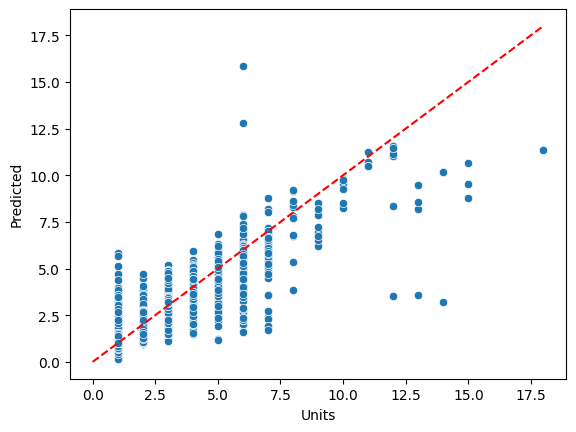

In [30]:
# Check if errors cluster around zero-sales days
sns.scatterplot(x=test['Units'], y=test['Predicted'])
plt.plot([0, max(test['Units'])], [0, max(test['Units'])], 'r--')

### Sales Prediction Performance Visualization

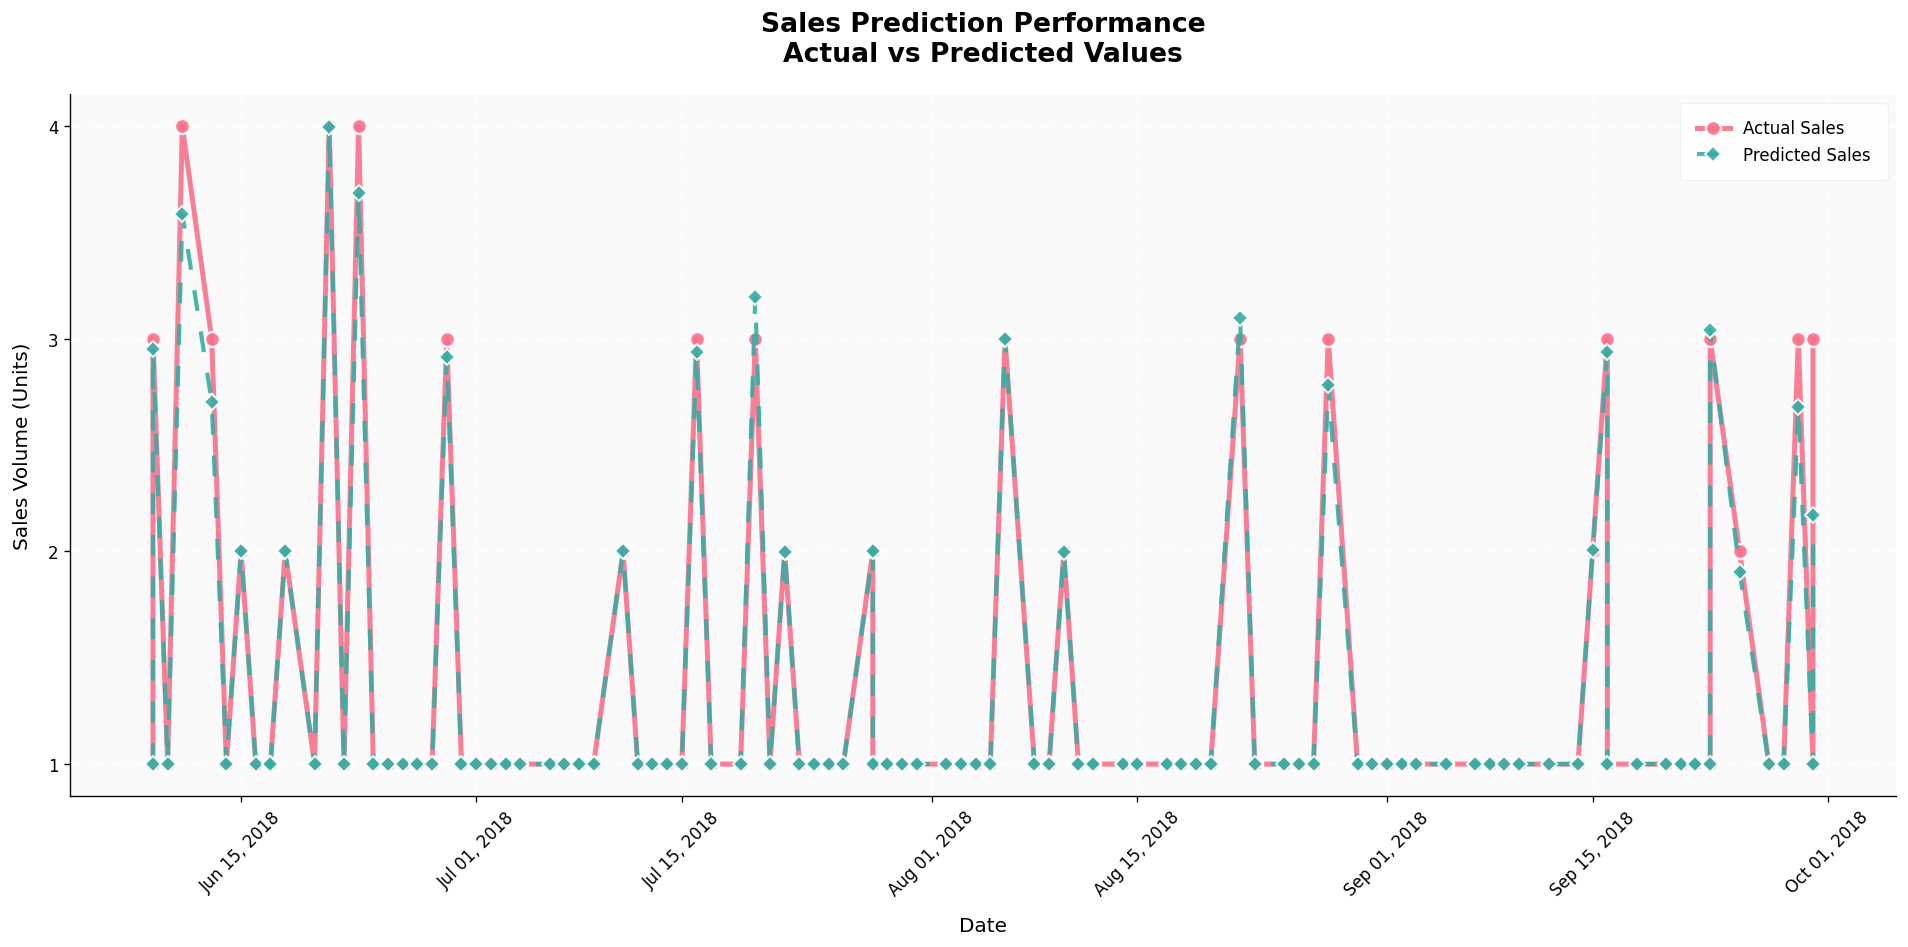

In [31]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Sample 100 points evenly across the time period
sample = test.iloc[np.linspace(0, len(test)-1, 100, dtype=int)].sort_values('Date')

# Custom color palette
palette = sns.color_palette("husl", 2)
actual_color = palette[0]  # Blue-green
predicted_color = palette[1]  # Red-orange

# Plot with enhanced styling
ax.plot(sample['Date'], sample[target], 
        label='Actual Sales', 
        color=actual_color,
        linewidth=3,
        marker='o',
        markersize=9,
        markeredgecolor='white',
        markeredgewidth=1.5,
        alpha=0.9)

ax.plot(sample['Date'], final_model.predict(sample[features]), 
        label='Predicted Sales', 
        color=predicted_color,
        linewidth=2.5,
        linestyle=(0, (5, 5)),  # Custom dashed pattern
        marker='D',
        markersize=7,
        markeredgecolor='white',
        markeredgewidth=1.2,
        alpha=0.9)


# Styling enhancements
ax.set_title('Sales Prediction Performance\nActual vs Predicted Values', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, labelpad=10)
ax.set_ylabel('Sales Volume (Units)', fontsize=12, labelpad=10)

# Configure grid and spines
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
fig.autofmt_xdate(rotation=45, ha='center')

# Modern legend
legend = ax.legend(frameon=True, loc='upper right', 
                  facecolor='white', framealpha=0.95,
                  edgecolor='#f0f0f0', borderpad=1)
legend.get_frame().set_linewidth(0.8)

# Add subtle background
ax.set_facecolor('#f9f9f9')
ax.grid(color='white', linewidth=1.5)

ax.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()

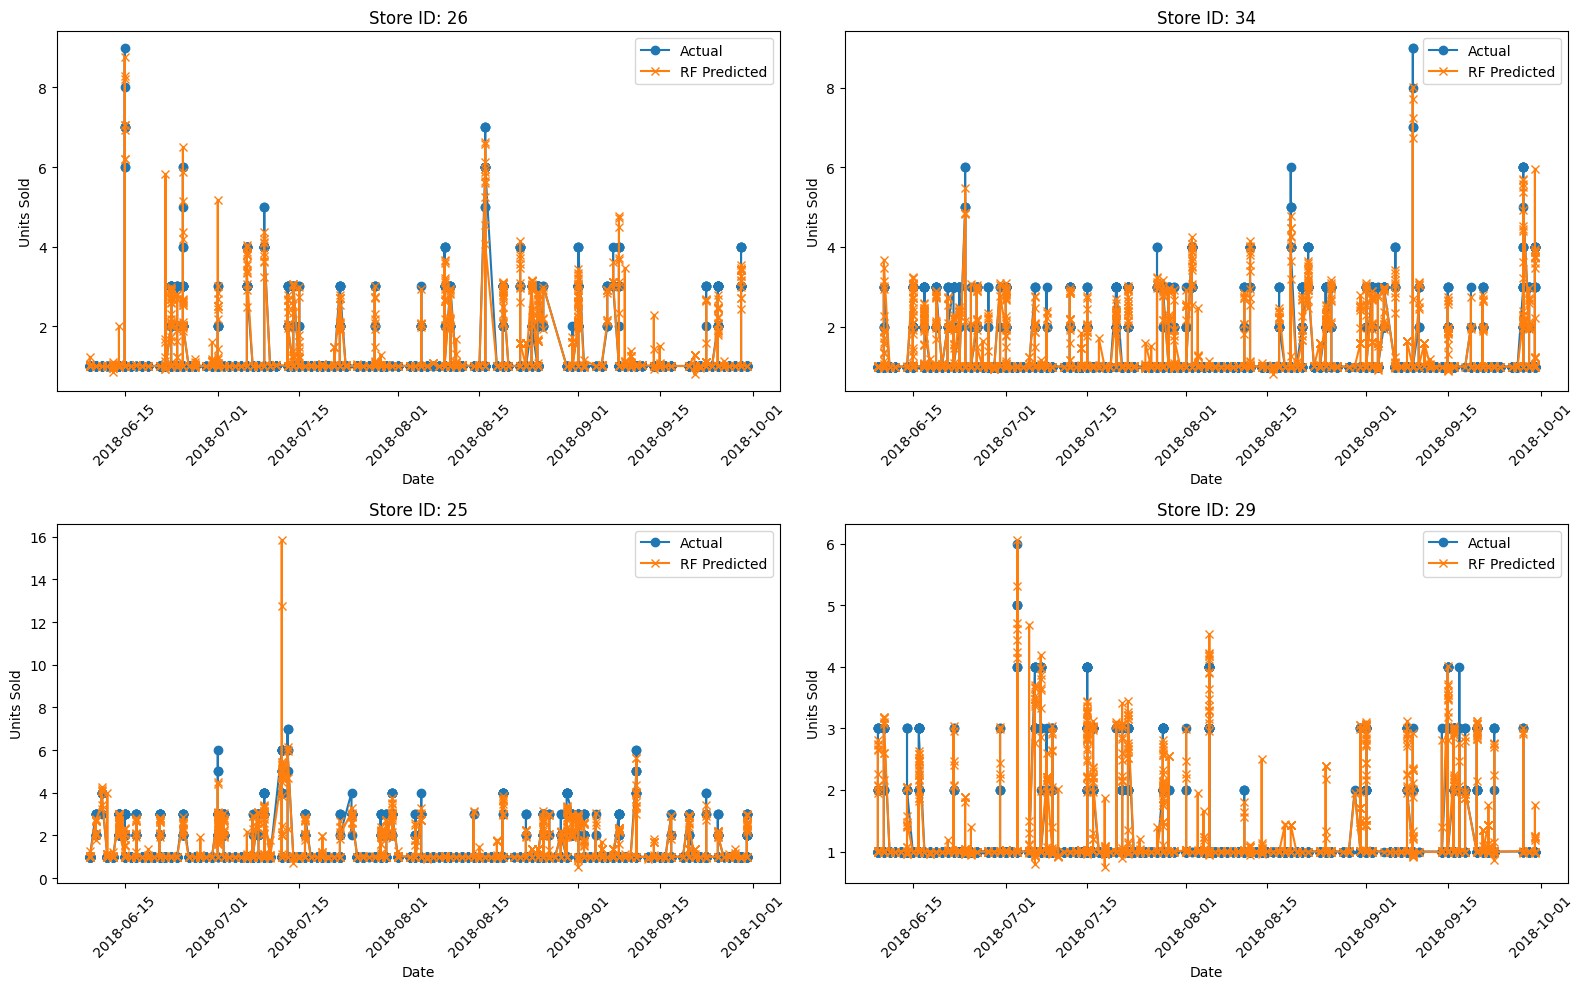

In [32]:
# First make predictions with Random Forest if not already done
if 'Predicted' not in test.columns:
    predictions = final_model.predict(test[features])
    test['Predicted'] = predictions

# Choose 4 store IDs 
selected_stores = test['Store_ID'].unique()[:4]  # Changed to 4 stores to fill all subplots

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

# Plot for each selected store
for i, store_id in enumerate(selected_stores):
    store_data = test[test['Store_ID'] == store_id].sort_values('Date')

    axes[i].plot(store_data['Date'], store_data['Units'], label='Actual', marker='o')
    axes[i].plot(store_data['Date'], store_data['Predicted'], label='RF Predicted', marker='x')
    axes[i].set_title(f'Store ID: {store_id}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Units Sold')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

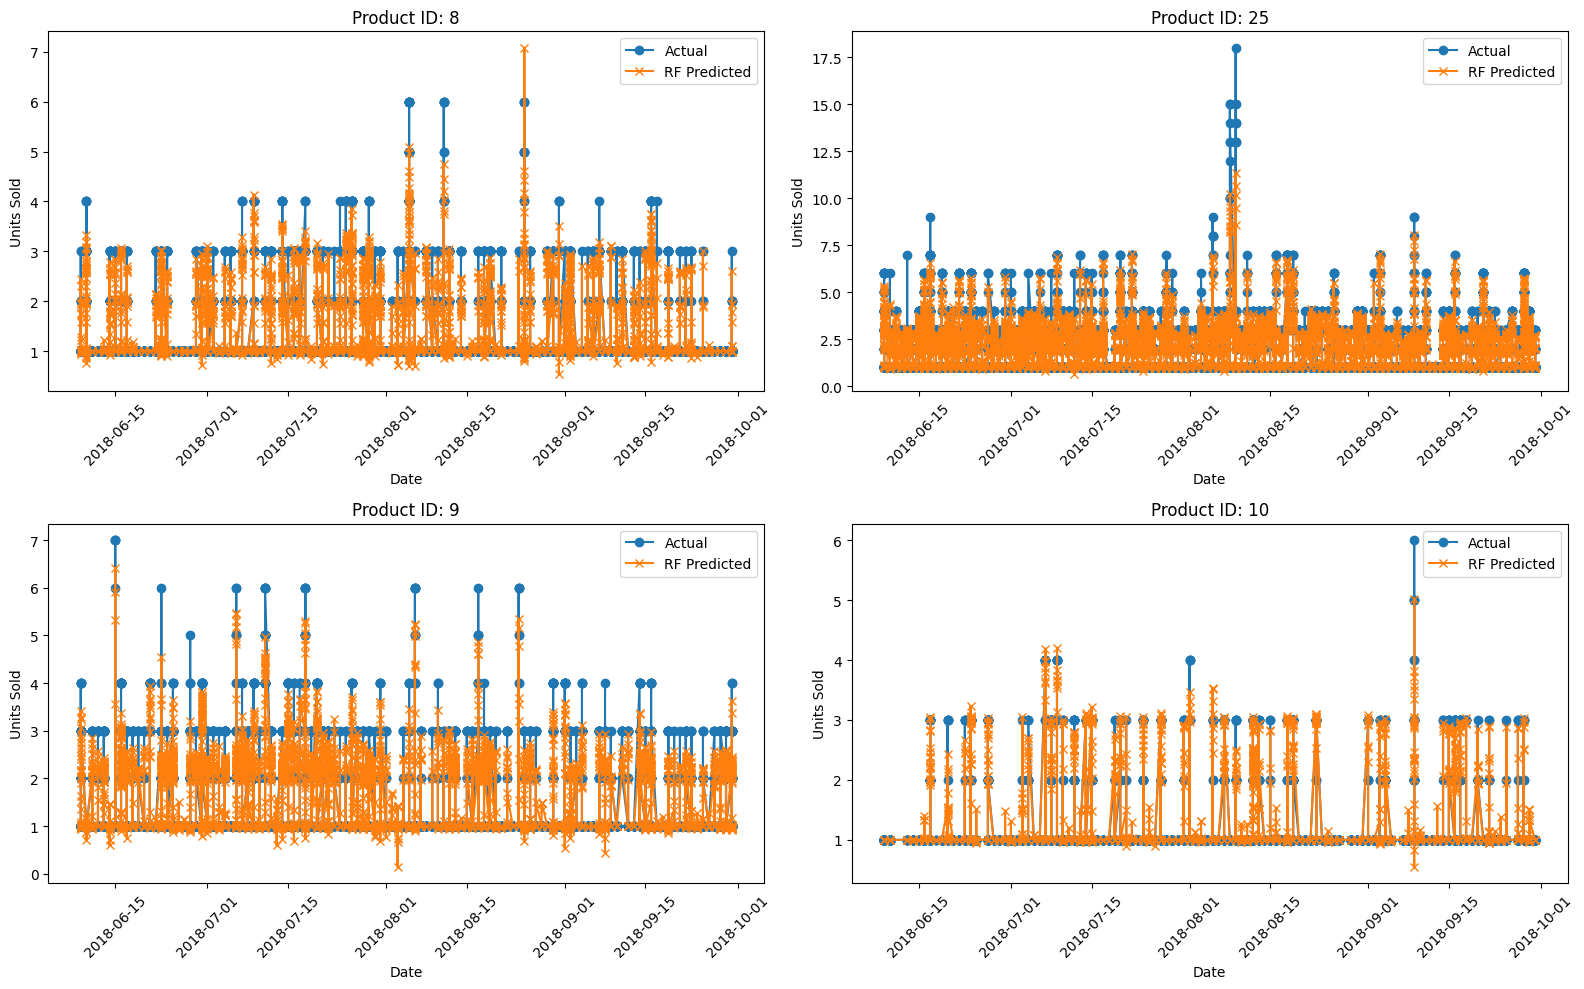

In [33]:
# First make predictions if not already done
if 'Predicted' not in test.columns:
    predictions = final_model.predict(test[features])
    test['Predicted'] = predictions

# Choose 4 Product IDs to visualize
selected_products = test['Product_ID'].unique()[:4]  # Adjust number as needed

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

# Plot for each selected product
for i, product_id in enumerate(selected_products):
    product_data = test[test['Product_ID'] == product_id].sort_values('Date')

    axes[i].plot(product_data['Date'], product_data['Units'], label='Actual', marker='o')
    axes[i].plot(product_data['Date'], product_data['Predicted'], label='RF Predicted', marker='x')
    axes[i].set_title(f'Product ID: {product_id}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Units Sold')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


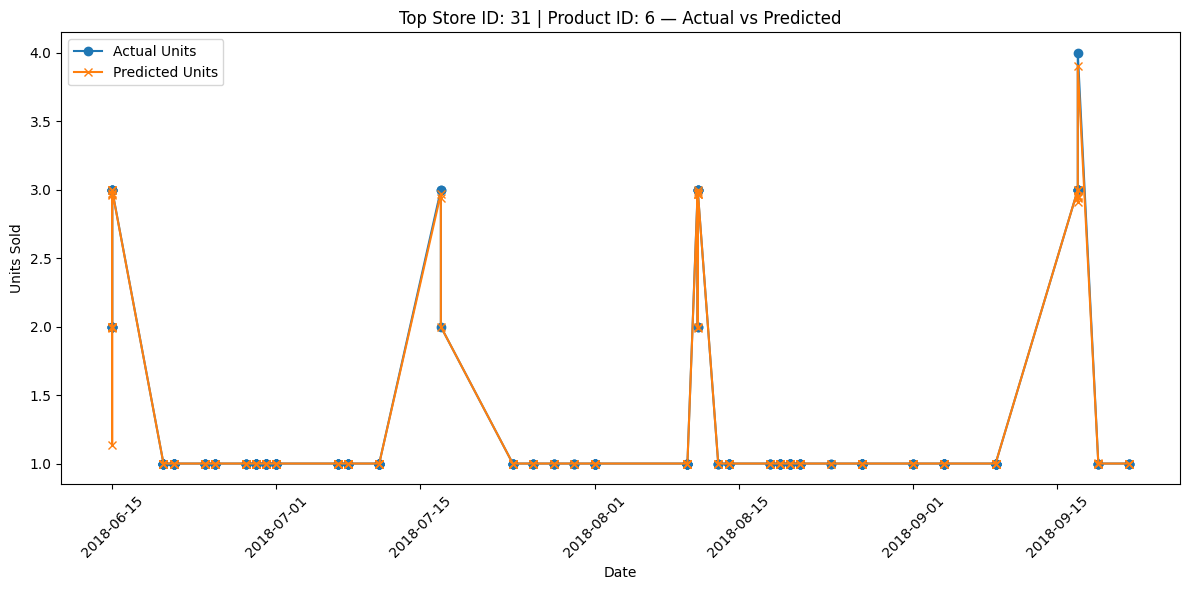

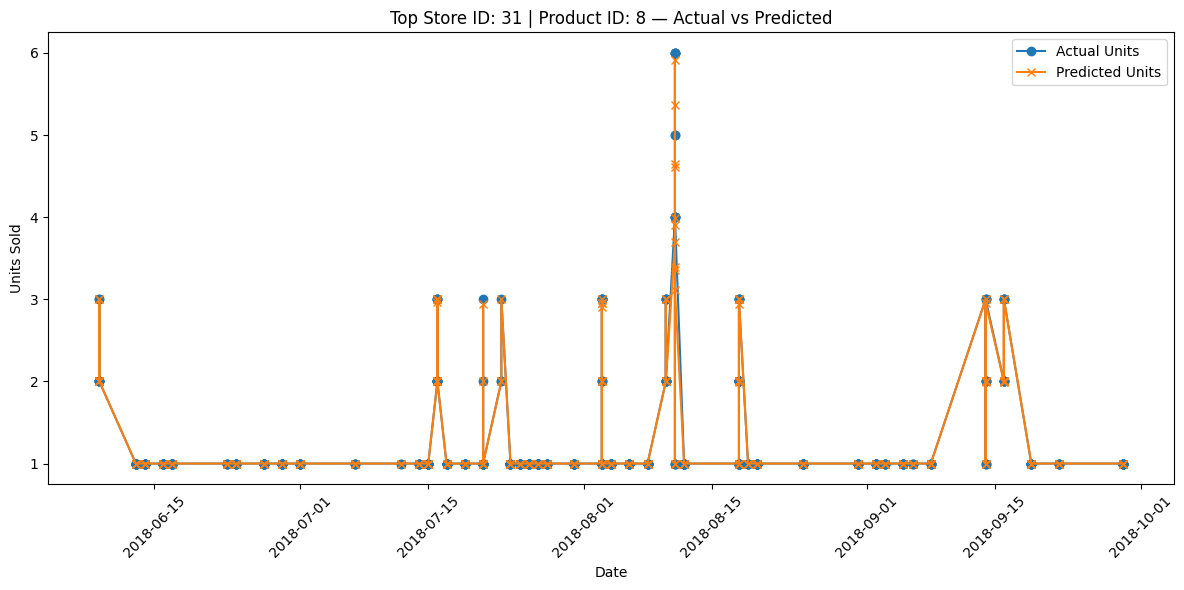

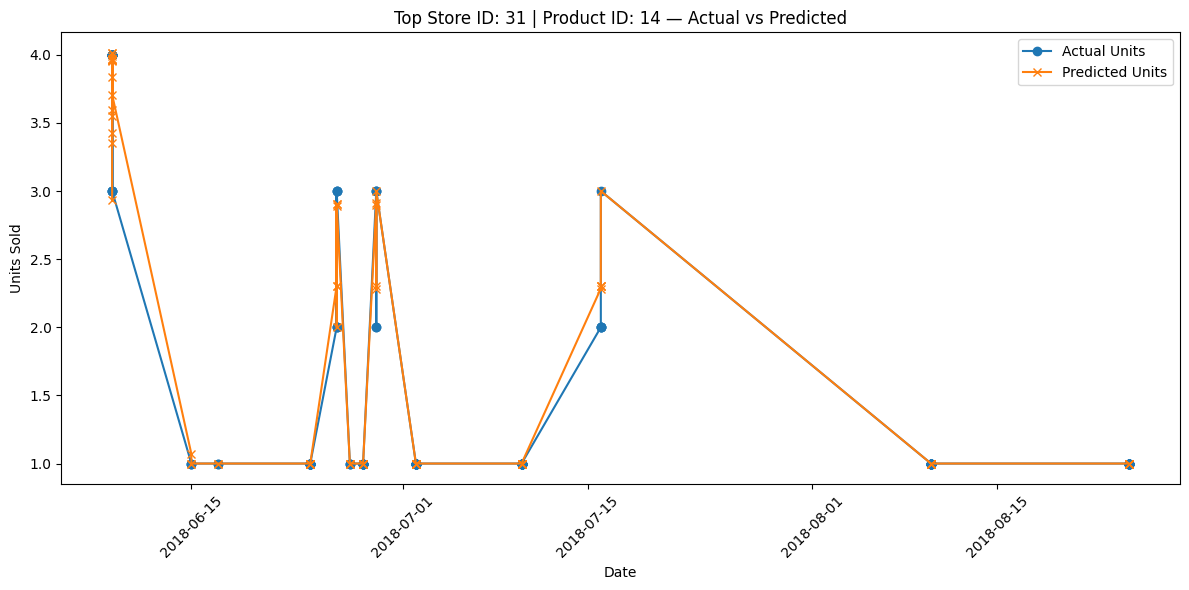

In [34]:
# --- Predict and Plot for Top 3 Products in Top Store ---
# Find the top store by total sales
best_store_id = merged_data.groupby('Store_ID')['sales'].sum().idxmax()

# Find top 3 products in that store by sales volume
top_products = (
    merged_data[merged_data['Store_ID'] == best_store_id]
    .groupby('Product_ID')['Units'].sum()
    .nlargest(3)
    .index.tolist()
)

# Plot predictions for each top product in the best store
for product_id in top_products:
    filtered_test = test[(test['Store_ID'] == best_store_id) & (test['Product_ID'] == product_id)].copy()
    if filtered_test.empty:
        continue
    filtered_test['Predicted'] = final_model.predict(filtered_test[features])

    plt.figure(figsize=(12, 6))
    plt.plot(filtered_test['Date'], filtered_test['Units'], label='Actual Units', marker='o')
    plt.plot(filtered_test['Date'], filtered_test['Predicted'], label='Predicted Units', marker='x')
    plt.title(f'Top Store ID: {best_store_id} | Product ID: {product_id} — Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
# Initialize an empty list to store prediction rows
prediction_rows = []

# Normalize dates to remove time (if not already done)
test['Date'] = pd.to_datetime(test['Date']).dt.normalize()

# --- Predict and Collect Data for Top 3 Products in Top Store ---
best_store_id = merged_data.groupby('Store_ID')['sales'].sum().idxmax()

top_products = (
    merged_data[merged_data['Store_ID'] == best_store_id]
    .groupby('Product_ID')['Units'].sum()
    .nlargest(3)
    .index.tolist()
)

# Collect and aggregate predictions
for product_id in top_products:
    filtered_test = test[(test['Store_ID'] == best_store_id) & (test['Product_ID'] == product_id)].copy()
    if filtered_test.empty:
        continue
    
    filtered_test['Predicted'] = final_model.predict(filtered_test[features])
    filtered_test['Predicted'] = np.round(filtered_test['Predicted']).astype(int)

    # Group by date to get total predicted units per day
    daily_pred = (
        filtered_test.groupby('Date')['Predicted']
        .sum()
        .reset_index()
        .rename(columns={'Predicted': 'units'})
    )
    daily_pred['store_id'] = best_store_id
    daily_pred['product_id'] = product_id

    prediction_rows.append(daily_pred)

# Combine all predictions into one DataFrame
predictions_df = pd.concat(prediction_rows, ignore_index=True)

# Add incremental ID column
predictions_df.insert(0, 'id', range(1, len(predictions_df) + 1))

# Save to CSV
predictions_df.to_csv('predicted_units.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

# Make sure 'Date' is normalized (remove time component)
test['Date'] = pd.to_datetime(test['Date']).dt.normalize()

# Predict and attach to test set
if 'Predicted' not in test.columns:
    test['Predicted'] = final_model.predict(test[features])
    test['Predicted'] = np.round(test['Predicted']).astype(int)

# Group by store, product, and date, then round the daily total
daily_predictions = (
    test.groupby(['Store_ID', 'Product_ID', 'Date'])['Predicted']
    .sum()
    .round()
    .astype(int)
    .reset_index()
)

# Rename columns to match Supabase table
daily_predictions.rename(columns={
    'Store_ID': 'store_id',
    'Product_ID': 'product_id',
    'Date': 'date',
    'Predicted': 'units'  # if still named Predicted (just in case)
}, inplace=True)

# Add incremental ID column
daily_predictions.insert(0, 'id', range(1, len(daily_predictions) + 1))

# Save to CSV
daily_predictions.to_csv('all_stores_products_predicted_units.csv', index=False)


### Save the Model

In [40]:
# Save both models
joblib.dump(final_model, 'random_forest_model.pkl')

print("Models saved successfully!")
print(type(model))



Models saved successfully!
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
